# Part 4 - Exercise: Regression toy problem

In this exercise, you are presented with a toy regression problem.
Your task is to adjust the code of the previous parts of the tutorial to this type of problem. 
- Adjust the loss function
- Try out different hyperparameters of the model and algorithm
- Optional: Implement early stopping. (If validation loss does not decrease anymore for certain number of iterations, stop training.)


In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime

### Data

In [2]:
def some_function(x):
    return np.sin(np.square(x)*2*np.pi) / x

In [3]:
num_samples = 200
noise_std = 0.25
np.random.seed(seed=42)

# Let's create some dataset of a deterministic function + gaussian noise.
x_train = np.expand_dims(np.random.uniform(low=-1.5, high=1.5, size=num_samples), axis=-1)
y_train = some_function(x_train) + np.random.normal(loc=0, scale=noise_std, size=[num_samples, 1])

x_test = np.expand_dims(np.linspace(-1.5, 1.5, 1000), axis=-1)
y_test = some_function(x_test)

Text(0.5,1,'noise-free test data')

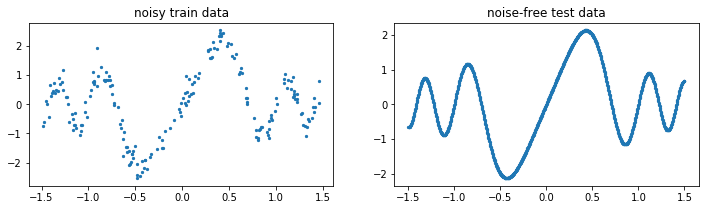

In [4]:
fig, axs = plt.subplots(1, 2, figsize=[12, 3])
axs[0].scatter(x_train, y_train, s=5)
axs[0].set_title("noisy train data")
axs[1].scatter(x_test, y_test, s=5)
axs[1].set_title("noise-free test data")

### Your code below

### Hyperparams & constants

In [5]:
dim_in, dim_out = 1, 1
num_iterations_train = 20000


dims_hidden = [128, 128]
activations_hidden = ["tanh", "tanh"]
batch_size = 128
learning_rate = 1e-3

### Model

In [6]:
class MLP():
    """ Multi-Layer-Perceptron """
    def __init__(self, name: str, dim_in: int, dim_out: int, dims_hidden: list, activations_hidden: list):
        self.name = name
        
        dims_in = [dim_in] + list(dims_hidden)  # [dim_in, hidden_1, hidden_2]
        dims_out = list(dims_hidden) + [dim_out]  # [hidden_1, hidden_2, dim_out]
        activations = list(activations_hidden) + ["linear"]
        
        self.layers = list()
        with tf.variable_scope(name, reuse=False):
            for idx_hidden, (d_in, d_out, activation) in enumerate(zip(dims_in, dims_out, activations)):
                # ***********************************************
                # 
                kernel_initializer, bias_initializer = self.get_initializers_for(activation=activation)
                layer = tf.keras.layers.Dense(units=d_out, 
                                              activation=activation, 
                                              name="layer_{}".format(idx_hidden), 
                                              kernel_initializer=kernel_initializer, 
                                              bias_initializer=bias_initializer,
                                             )
                layer.build(d_in)
                # ***********************************************
                self.layers.append(layer)

    def __call__(self, x):
        h = x
        for layer in self.layers:
            h = layer(h)
        return h
    
    def get_initializers_for(self, activation: str, distribution: str = "uniform", mode : str = "fan_in"):
        """ 
        Helper function to choose appropriate initialization method, depending on the activation function. 
        """
        if not isinstance(activation, str):
            activation = activation.__name__

        if activation in [None, 'linear']:
            scale = 1.0
        elif activation is "relu":
            scale = 2.0  
        elif activation is "tanh":
            scale = 1.32
        else:
            raise ValueError("unexpected activation function: {}".format(activation))

        kernel_initializer = tf.initializers.variance_scaling(
            scale=scale,
            mode=mode,
            distribution=distribution,
        )
        bias_initializer = tf.initializers.constant(0.0)
        return kernel_initializer, bias_initializer

In [7]:
tf.reset_default_graph()  # Might be helpful, if you rebuild your model.

# Batch size None means that batch size is define by the data provided by the feed_dict to session.run()
targets = tf.placeholder(shape=[None, dim_out], dtype=tf.float32, name="targets")  
inputs = tf.placeholder(shape=[None, dim_in], dtype=tf.float32, name="inputs")
model = MLP(name="MLP", 
            dim_in=dim_in, 
            dim_out=dim_out,
            dims_hidden=dims_hidden,  # last dimension is for output layer.
            activations_hidden=activations_hidden,  # Output has no activation function.
           )
outputs = model(inputs) 

In [8]:
def get_loglikelihood(locs, targets):
    raise NotImplementedError("Please implement this function.")

In [9]:
loss = - get_loglikelihood(locs=outputs, targets=targets)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_step = optimizer.minimize(loss)

In [10]:
saver = tf.train.Saver(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES))
sess = tf.Session()
sess.run(tf.global_variables_initializer()) # Initializes weights and biases.

In [11]:
# Note: Usually you would validate your model during training on a held out dataset, as in the previous tutorial.
# The validation loss can be used to prevent overfitting and to stop training (early stopping).
for iter_train in range(num_iterations_train):  
    indices = np.random.random_integers(low=0, high=len(x_train) - 1, size=batch_size)
    batch_inputs, batch_targets = x_train[indices], y_train[indices]
    feed_dict = {inputs: batch_inputs, targets: batch_targets}
    _, train_loss = sess.run([train_step, loss], feed_dict=feed_dict)

/Users/Richard/.virtualenvs/tf_tutorial/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: This function is deprecated. Please call randint(0, 199 + 1) instead
  after removing the cwd from sys.path.


### Evaluation 

In [12]:
predictions_train = sess.run(outputs, feed_dict={inputs: x_train})
predictions_test = sess.run(outputs, feed_dict={inputs: x_test})

Text(0.5,1,'noise-free test data')

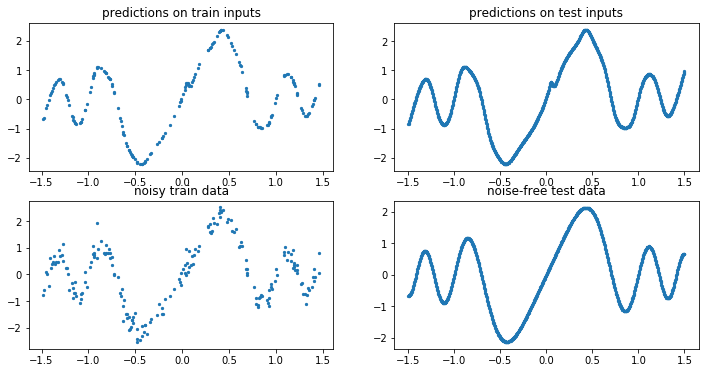

In [13]:
fig, axs = plt.subplots(2, 2, figsize=[12, 6])

axs[0, 0].scatter(x_train, predictions_train, s=5)
axs[0, 0].set_title("predictions on train inputs")
axs[0, 1].scatter(x_test, predictions_test, s=5)
axs[0, 1].set_title("predictions on test inputs")

axs[1, 0].scatter(x_train, y_train, s=5)
axs[1, 0].set_title("noisy train data")
axs[1, 1].scatter(x_test, y_test, s=5)
axs[1, 1].set_title("noise-free test data")

## Things to try out...

- Evaluate the model on a larger input range (e.g. -2.5 ... 2.5). How well does the model generalize outside of the range of the training data?
- Overparametrize the model (e.g. hidden layers [128, 128])
- Compare ReLU activations to tanh
- Try other learning rates or optimizers (e.g. plain GradientDescent, Momentum)